In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
import sys

In [2]:
# Set folder paths for train and test data
train_folder_path = "../data/train/"
test_folder_path = "../data/test/"

In [3]:
# Get the files from train and test folders
train_files = os.listdir(train_folder_path)
test_files = os.listdir(test_folder_path)

# Check the number of files
print(f"Number of train images : {len(train_files)}")
print(f"Number of test images : {len(test_files)}")

Number of train images : 25000
Number of test images : 12500


In [4]:
# Check the filename structure for train files
train_files[:10]

['dog.8011.jpg',
 'cat.5077.jpg',
 'dog.7322.jpg',
 'cat.2718.jpg',
 'cat.10151.jpg',
 'cat.3406.jpg',
 'dog.1753.jpg',
 'cat.4369.jpg',
 'cat.7660.jpg',
 'dog.5535.jpg']

In [5]:
# Check the filename structure for test files
test_files[:10]

['9733.jpg',
 '63.jpg',
 '6400.jpg',
 '823.jpg',
 '4217.jpg',
 '3578.jpg',
 '10321.jpg',
 '2666.jpg',
 '5109.jpg',
 '11981.jpg']

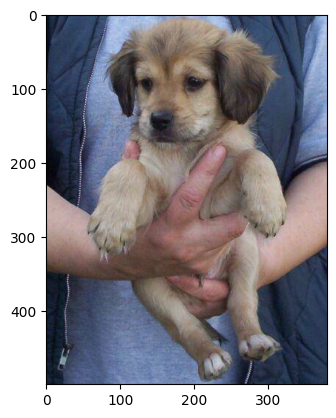

In [6]:
# Display example images from train data
from PIL import Image
k = 0
image = Image.open(train_folder_path + train_files[k])
plt.imshow(image)
plt.show()

In [81]:
# Define a function to extract the label from the training data
LABEL_TO_IDX = {"dog": 0, "cat": 1}
IDX_TO_LABEL = {0: "dog", 1: "cat"}

def get_image_labels(filepaths: list[str]) -> list[int]:
    return [LABEL_TO_IDX[filepath.split(".")[0]] for filepath in filepaths]

In [58]:
# Define the image size used for our neural network
IMG_SIZE = 224

def process_image(filepath: str) -> tf.Tensor:
    """
    Takes an image filepath and turns it into a Tensor.
    """

    # Read in image file
    image = tf.io.read_file(filepath) 
    # Turn the jpeg into numerical Tensor with 3 color channels RGB
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert color channel values from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize image to our desired IMG_SIZE
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image

In [59]:
process_image(train_folder_path + train_files[0])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.08697386, 0.12618954, 0.17324837],
        [0.05588236, 0.10311625, 0.15836835],
        [0.08130723, 0.13228762, 0.19793889],
        ...,
        [0.6399298 , 0.7410154 , 0.8978781 ],
        [0.62955767, 0.7393616 , 0.8962244 ],
        [0.6492307 , 0.7590347 , 0.9158974 ]],

       [[0.08175771, 0.1209734 , 0.16803221],
        [0.04062469, 0.08785858, 0.14311068],
        [0.07280821, 0.1237886 , 0.18943986],
        ...,
        [0.653445  , 0.763249  , 0.9172056 ],
        [0.64586836, 0.75567234, 0.9125351 ],
        [0.64352524, 0.7533292 , 0.91019195]],

       [[0.07303453, 0.11225022, 0.15930904],
        [0.02256309, 0.06979698, 0.1250491 ],
        [0.06477594, 0.11575633, 0.18140762],
        ...,
        [0.61030656, 0.7198657 , 0.8757946 ],
        [0.63920164, 0.7480602 , 0.9013165 ],
        [0.64652896, 0.75538754, 0.90864384]],

       ...,

       [[0.11842662, 0.13803445, 0.2607936 ],
        [0.11

In [60]:
def process_image_label(filepath: str, label: int) -> tuple[tf.Tensor, int]:
    """
    Takes an image filepath name and label, processes the image and
    returns an (image, label) tuple.
    """

    image = process_image(filepath)
    return image, label

In [61]:
filepath = train_files[0]
process_image_label(train_folder_path + filepath, get_image_labels([filepath]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.08697386, 0.12618954, 0.17324837],
         [0.05588236, 0.10311625, 0.15836835],
         [0.08130723, 0.13228762, 0.19793889],
         ...,
         [0.6399298 , 0.7410154 , 0.8978781 ],
         [0.62955767, 0.7393616 , 0.8962244 ],
         [0.6492307 , 0.7590347 , 0.9158974 ]],
 
        [[0.08175771, 0.1209734 , 0.16803221],
         [0.04062469, 0.08785858, 0.14311068],
         [0.07280821, 0.1237886 , 0.18943986],
         ...,
         [0.653445  , 0.763249  , 0.9172056 ],
         [0.64586836, 0.75567234, 0.9125351 ],
         [0.64352524, 0.7533292 , 0.91019195]],
 
        [[0.07303453, 0.11225022, 0.15930904],
         [0.02256309, 0.06979698, 0.1250491 ],
         [0.06477594, 0.11575633, 0.18140762],
         ...,
         [0.61030656, 0.7198657 , 0.8757946 ],
         [0.63920164, 0.7480602 , 0.9013165 ],
         [0.64652896, 0.75538754, 0.90864384]],
 
        ...,
 
        [[0.11842662, 0.13803445

In [75]:
from typing import Literal
# Define the batch size
BATCH_SIZE = 32

def create_data_batches(filepaths: list[str], batch_size: int = BATCH_SIZE, data_type: Literal["train", "valid", "test"] = "train") -> tf.data.Dataset:
    """
    Create batches of data out of image, label pairs.
    Accepts train, valid, and test data and performs appropriate operations for each.
    """

    if data_type == "test":
        X = tf.constant(test_folder_path) + tf.constant(filepaths)
        data = tf.data.Dataset.from_tensor_slices(X) # filepaths, labels
        data_batch = data.map(process_image).batch(batch_size) 
    elif data_type == "valid":
        X = tf.constant(train_folder_path) + tf.constant(filepaths)
        y = tf.constant(get_image_labels(filepaths))
        data = tf.data.Dataset.from_tensor_slices((X, y)) # filepaths, labels
        data_batch = data.map(process_image_label).batch(batch_size) 
    elif data_type == "train":
        X = tf.constant(train_folder_path) + tf.constant(filepaths)
        y = tf.constant(get_image_labels(filepaths))
        data = tf.data.Dataset.from_tensor_slices((X, y)) # filepaths, labels
        data_batch = data.shuffle(buffer_size=len(X)).map(process_image_label).batch(batch_size)
    else:
        raise ValueError(f"Invalid data_type {data_type} given.")
    return data_batch

In [76]:
from sklearn.model_selection import train_test_split

train_filepaths, valid_filepaths = train_test_split(train_files, test_size=0.2)
test_filepaths = test_files

In [78]:
train_ds = create_data_batches(train_filepaths, data_type="train")
valid_ds = create_data_batches(valid_filepaths, data_type="valid")
test_ds = create_data_batches(test_filepaths, data_type="test")

In [79]:
train_ds.element_spec, valid_ds.element_spec, test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))

In [85]:
def show_images(images: np.ndarray, labels: np.ndarray) -> None:
    """
    Displays batch of images.
    """

    # Setup figure
    plt.figure(figsize=(10, 10))
    # Loop through images
    for i, image in enumerate(images):
        ax = plt.subplot(8, 4, i+1)
        ax.imshow(image)
        ax.set(title=IDX_TO_LABEL[labels[i]])
        ax.axis("off")
    plt.tight_layout()

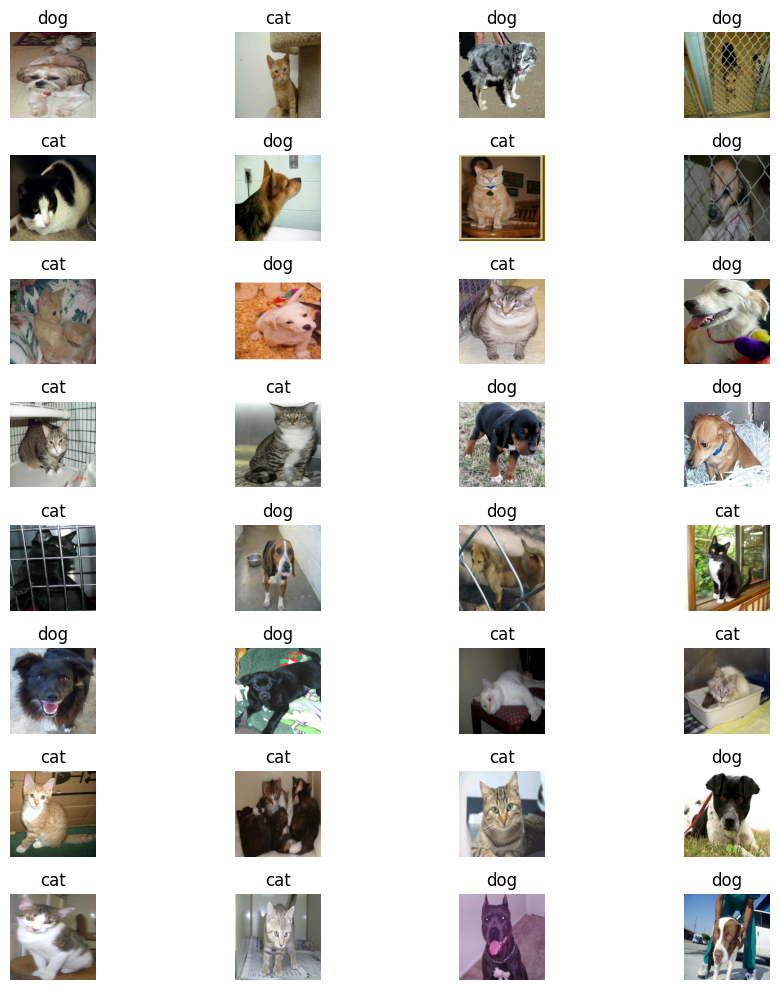

In [87]:
images, labels = next(train_ds.as_numpy_iterator())
show_images(images, labels)

### Modelling

In [89]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = 1 # number of unique labels

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/classification/versions/1"

In [90]:
import tensorflow_hub as hub

def create_model(input_shape: list[int] = INPUT_SHAPE, output_shape: int = OUTPUT_SHAPE, model_url: str = MODEL_URL):
    """
    """

    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url),
        tf.keras.layers.Dense(units=output_shape, activation="sigmoid")
    ])

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # Build model
    model.build(input_shape)

    return model

In [91]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25612201  
                                                                 
 dense (Dense)               (None, 1)                 1002      
                                                                 
Total params: 25613203 (97.71 MB)
Trainable params: 1002 (3.91 KB)
Non-trainable params: 25612201 (97.70 MB)
_________________________________________________________________


In [94]:
# Create an early stopping callback
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3
)

checkpoint_path = "../models/"
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    verbose=1
)

In [95]:
NUM_EPOCHS = 5

model.fit(x=train_ds, validation_data=valid_ds, epochs=NUM_EPOCHS, callbacks=[earlystopping, modelcheckpoint])

Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9784
Epoch 1: val_loss improved from inf to 0.23980, saving model to ../models/
INFO:tensorflow:Assets written to: ../models/assets


INFO:tensorflow:Assets written to: ../models/assets


625/625 [==============================] - 104s 167ms/step - loss: 0.2700 - accuracy: 0.9784 - val_loss: 0.2398 - val_accuracy: 0.9808
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 0.2235 - accuracy: 0.9788
Epoch 2: val_loss improved from 0.23980 to 0.19912, saving model to ../models/
INFO:tensorflow:Assets written to: ../models/assets


INFO:tensorflow:Assets written to: ../models/assets


625/625 [==============================] - 104s 166ms/step - loss: 0.2235 - accuracy: 0.9788 - val_loss: 0.1991 - val_accuracy: 0.9808
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9788
Epoch 3: val_loss improved from 0.19912 to 0.16792, saving model to ../models/
INFO:tensorflow:Assets written to: ../models/assets


INFO:tensorflow:Assets written to: ../models/assets


625/625 [==============================] - 102s 163ms/step - loss: 0.1881 - accuracy: 0.9788 - val_loss: 0.1679 - val_accuracy: 0.9810
Epoch 4/5
625/625 [==============================] - ETA: 0s - loss: 0.1607 - accuracy: 0.9793
Epoch 4: val_loss improved from 0.16792 to 0.14366, saving model to ../models/
INFO:tensorflow:Assets written to: ../models/assets


INFO:tensorflow:Assets written to: ../models/assets


625/625 [==============================] - 103s 165ms/step - loss: 0.1607 - accuracy: 0.9793 - val_loss: 0.1437 - val_accuracy: 0.9812
Epoch 5/5
625/625 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9793
Epoch 5: val_loss improved from 0.14366 to 0.12467, saving model to ../models/
INFO:tensorflow:Assets written to: ../models/assets


INFO:tensorflow:Assets written to: ../models/assets


625/625 [==============================] - 103s 164ms/step - loss: 0.1393 - accuracy: 0.9793 - val_loss: 0.1247 - val_accuracy: 0.9822


In [96]:
# Create predictions on test data
y_pred = model.predict(test_ds)

391/391 [==============================] - 50s 126ms/step


In [105]:
submission = pd.DataFrame(y_pred.round().astype(int), index=range(1, len(y_pred) + 1))
submission_path = "../submissions/dogs-vs-cats.csv"
submission.to_csv(submission_path)